# Initialize simulator

In [11]:
import numpy as np
from backend.simulation_tools import Simulator
from tasks import flip_flop
import matplotlib.pyplot as plt
%matplotlib inline

params = flip_flop.set_params(N_batch= 64, N_rec=10,
                       input_wait=5, stim_dur=10, quiet_gap=20, N_turns=2,
                       rec_noise=0, stim_noise=0,
                       dale_ratio=.8, tau=100, dt=10.)

x,y,mask = flip_flop.build_train_batch(params)

sim = Simulator(params, weights_path="./tasks/weights/flipflop.npz")



# Choose a trial

In [12]:
trial = x[4]
target = y[4]

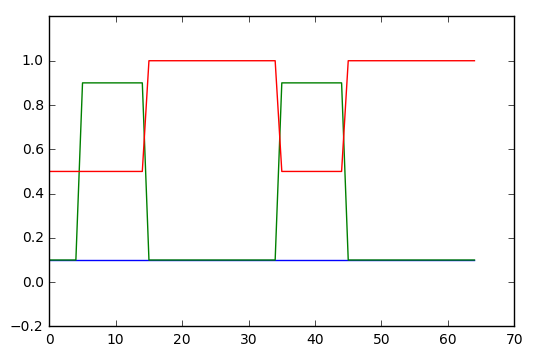

In [13]:
plt.plot(range(x.shape[1]), trial[:,0], range(x.shape[1]), trial[:,1], range(x.shape[1]), target)
plt.ylim([-.2, 1.2])
plt.show()


# Add selective time masking, run the trial

In [14]:
t_connectivity = []

for i in range(x.shape[1]):
    if 5 <= i and i <= 4:
        t_connectivity.append(np.zeros_like(sim.W_rec))
    else:
        t_connectivity.append(np.ones_like(sim.W_rec))

In [15]:
outputs, states = sim.run_trial(trial, t_connectivity)


# Plot output of network

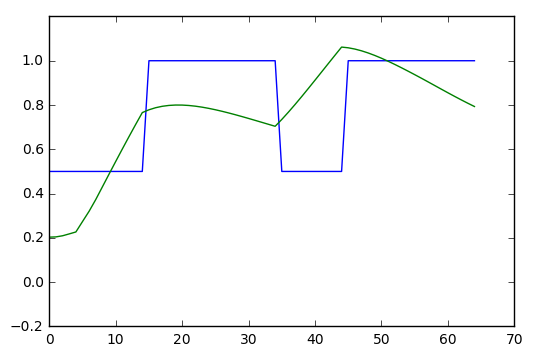

In [16]:
plt.plot(range(x.shape[1]), target, range(x.shape[1]), outputs[:,0])
plt.ylim([-.2, 1.2])
plt.show()

# Plot states over time, without and with RELU

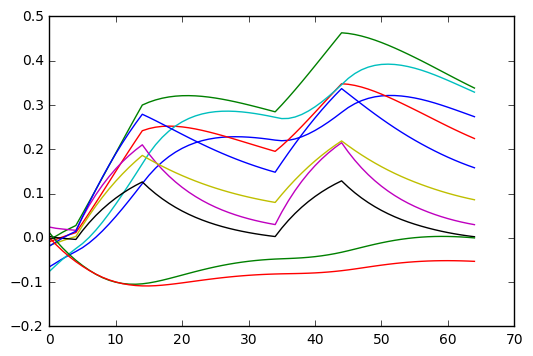

In [17]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), states[:,0,i])
plt.show()

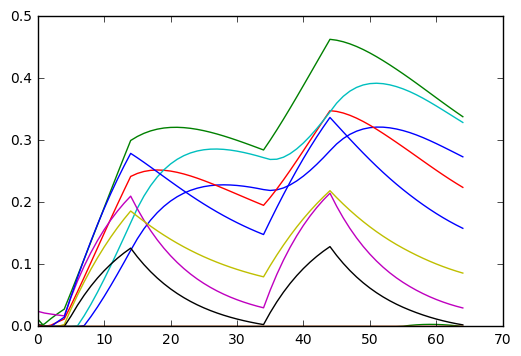

In [18]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), np.maximum(states[:,0,i], np.zeros_like(states[:,0,i])))
plt.show()

# Plot W_rec and then animate effective W_rec given state and RELU

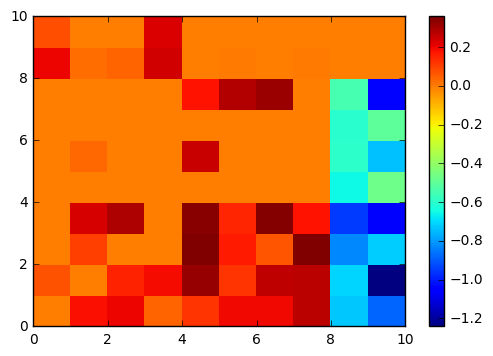

In [19]:
plt.pcolor(sim.W_rec)
plt.colorbar()
plt.show()

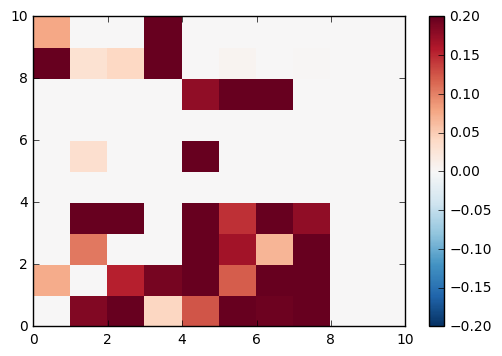

In [20]:
import matplotlib.animation as animation 
from IPython.display import HTML
from matplotlib import rc

fig = plt.figure()
    
ims = []


for i in range(states.shape[2]):
    Wi = np.matmul(np.absolute(sim.W_rec),sim.dale_rec) * t_connectivity[i]
    for j in range(sim.W_rec.shape[0]):
        if states[i, 0, j] < 0:
            Wi[:, j] = 0
    ims.append((plt.pcolor(Wi, vmin = -.2, vmax = .2, cmap='RdBu_r'),))

plt.colorbar()
rc('animation', html='html5')


animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=3000,
                                   blit=True)

# Effective input and output matrices

In [88]:
np.absolute(sim.W_in)

array([[  1.70115459e-06,   1.35755854e-05],
       [  5.29421319e-04,   1.69477075e-01],
       [  1.66308149e-04,   1.20023303e-01],
       [  3.38974292e-04,   4.77637537e-02],
       [  9.87246767e-06,   2.76837345e-05],
       [  5.87706512e-04,   5.13086125e-05],
       [  6.66892505e-04,   5.71005382e-02],
       [  1.41993398e-04,   1.48481607e-01],
       [  8.19391608e-01,   3.41656408e-03],
       [  8.62619102e-01,   1.33272063e-03]], dtype=float32)

In [87]:
np.matmul(np.absolute(sim.W_out),sim.dale_out)

array([[ 0.01384992,  0.78881299,  0.59625286,  0.37853906,  0.01420289,
         0.00201356,  0.41047218,  0.54181677,  0.        ,  0.        ]])

# "Black Box" paper analysis

In [ ]:
def q(x, rnn_in):
    f = (1.0 / sim.tau) * (-x + np.matmul(np.maximum(x, np.zeros_like(x)),
                                np.transpose(np.matmul(np.absolute(sim.W_rec),sim.dale_rec))) +
                               